<a href="https://colab.research.google.com/github/rich-hyun/5th-Static-Competition/blob/main/static_jaehyun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터

In [32]:
!pip install scikit-learn
!pip install lightgbm xgboost

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
#데이터 시각화

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset to understand its structure
df.head()


,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,City,Temp_Range,Heat_Index,Severity_Score,Condition_Code,Month,Season,Day_of_Week,Is_Weekend,Health_Risk_Score
0,2024-09-07,1725692400,106.1,91.0,98.5,104.0,88.1,95.9,51.5,21.0,...,Phoenix,15.1,95.918703,4.4300,NaN,9,Fall,Saturday,True,10.522170
1,2024-09-08,1725778800,103.9,87.0,95.4,100.5,84.7,92.3,48.7,21.5,...,Phoenix,16.9,92.281316,3.8800,0.0,9,Fall,Sunday,True,10.062332
2,2024-09-09,1725865200,105.0,83.9,94.7,99.9,81.6,90.6,41.7,16.9,...,Phoenix,21.1,90.599165,3.6300,0.0,9,Fall,Monday,False,9.673387
3,2024-09-10,1725951600,106.1,81.2,93.9,100.6,79.5,89.8,39.1,15.7,...,Phoenix,24.9,89.638811,2.8512,0.0,9,Fall,Tuesday,False,9.411519
4,2024-09-11,1726038000,106.1,82.1,94.0,101.0,80.0,90.0,40.1,15.9,...,Phoenix,24.0,89.760414,3.3908,0.0,9,Fall,Wednesday,False,9.515179


<ipython-input-27-748571521f82>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='plasma')


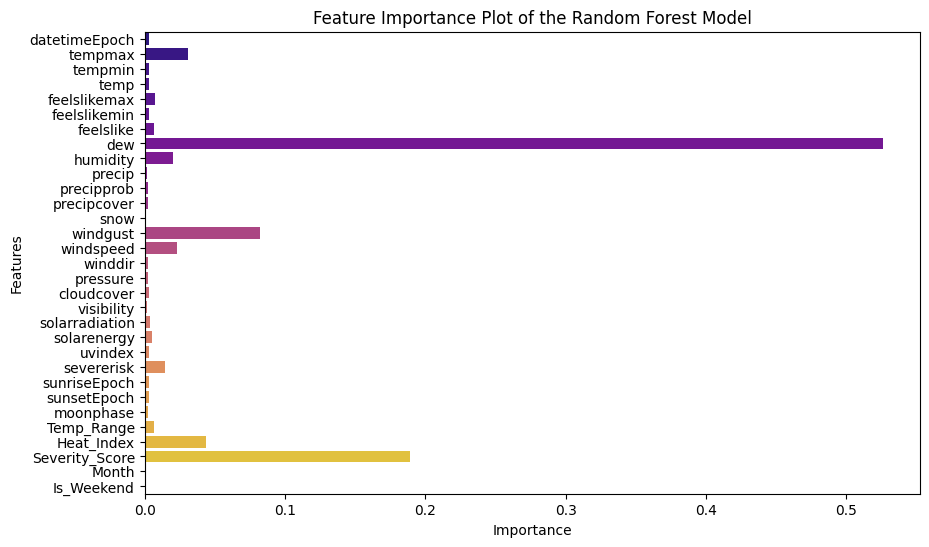

In [27]:
# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

# 변수 중요도 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='plasma')
plt.title('Feature Importance Plot of the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [30]:
#선별된 데이터의 randomforest 결과

# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

y_pred_rf
y_test
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, r2_rf

(0.08533279983758309, 0.9674450275362524)

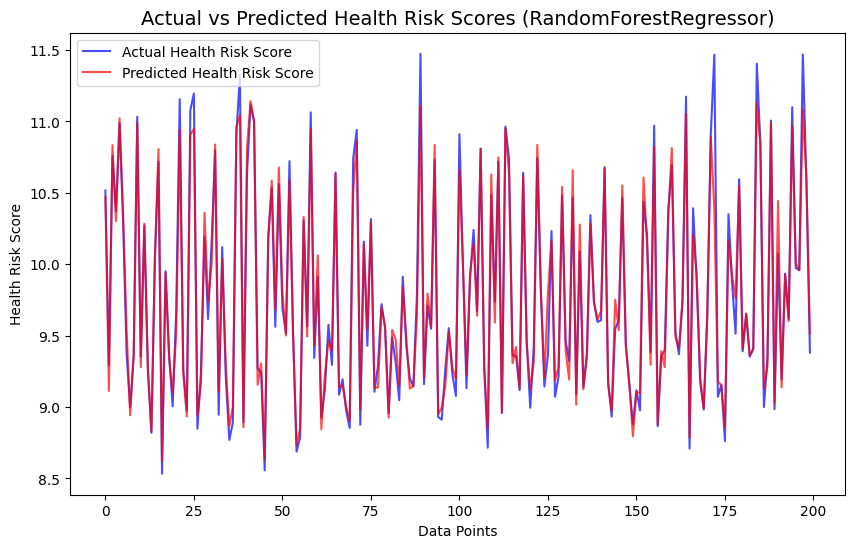

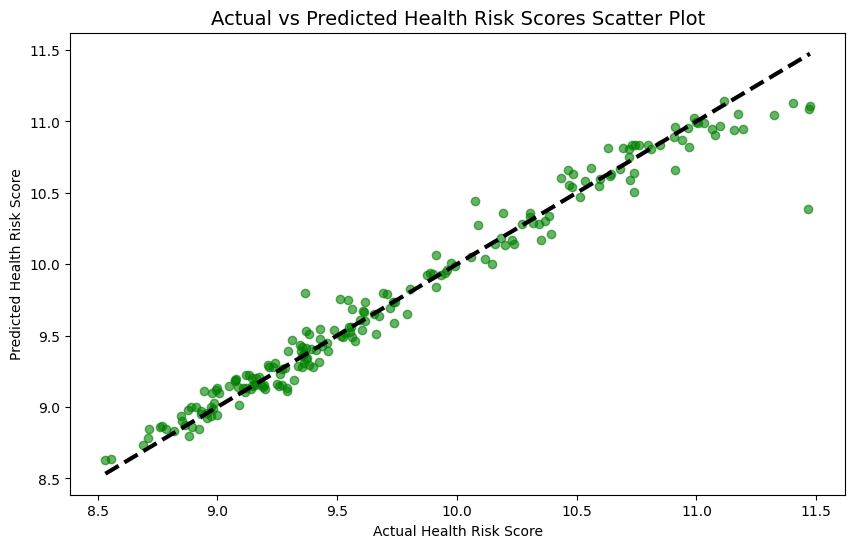

In [31]:
#실제 값과 차이 출력

# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(10, 6))

# 실제 값과 예측 값의 차이를 막대 그래프로 표현
plt.plot(np.arange(len(y_test)), y_test, label='Actual Health Risk Score', color='blue', alpha=0.7)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted Health Risk Score', color='red', alpha=0.7)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores (RandomForestRegressor)', fontsize=14)
plt.xlabel('Data Points')
plt.ylabel('Health Risk Score')
plt.legend()

# 시각화 출력
plt.show()

# 오차 분포 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores Scatter Plot', fontsize=14)
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# 시각화 출력
plt.show()

In [38]:
# 필요한 라이브러리 불러오기
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import json

# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 결과 출력
results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7143
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 29
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

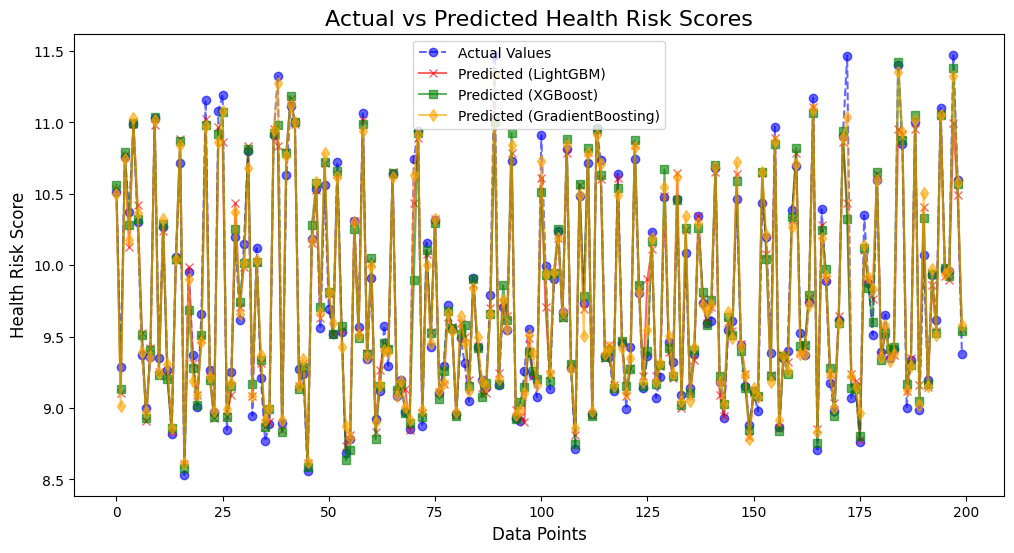

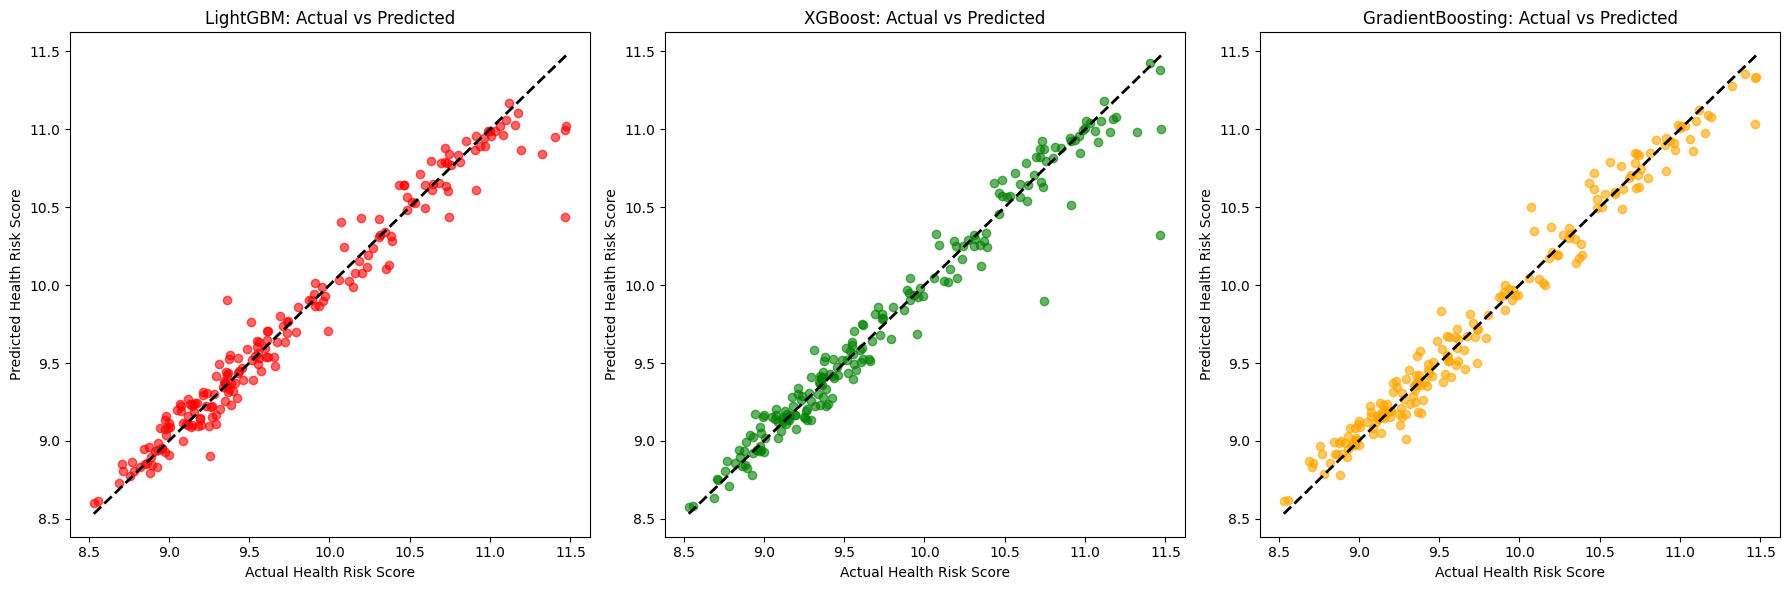

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 선형 그래프: 실제값 vs 예측값
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual Values', color='blue', linestyle='--', marker='o', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_lgbm, label='Predicted (LightGBM)', color='red', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='-', marker='s', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_gbr, label='Predicted (GradientBoosting)', color='orange', linestyle='-', marker='d', alpha=0.6)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Health Risk Score', fontsize=12)
plt.legend()
plt.show()

# 2. 산포도: 실제값 vs 예측값 (LightGBM, XGBoost, GradientBoosting)
plt.figure(figsize=(18, 6))

# LightGBM
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lgbm, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# XGBoost
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# GradientBoosting
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_gbr, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('GradientBoosting: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# 그래프 표시
plt.tight_layout()
plt.show()

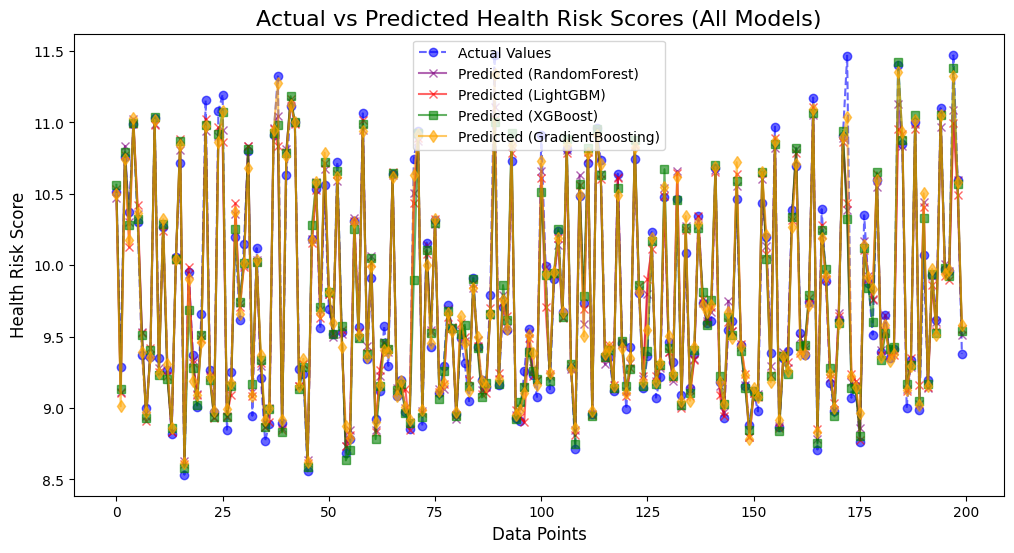

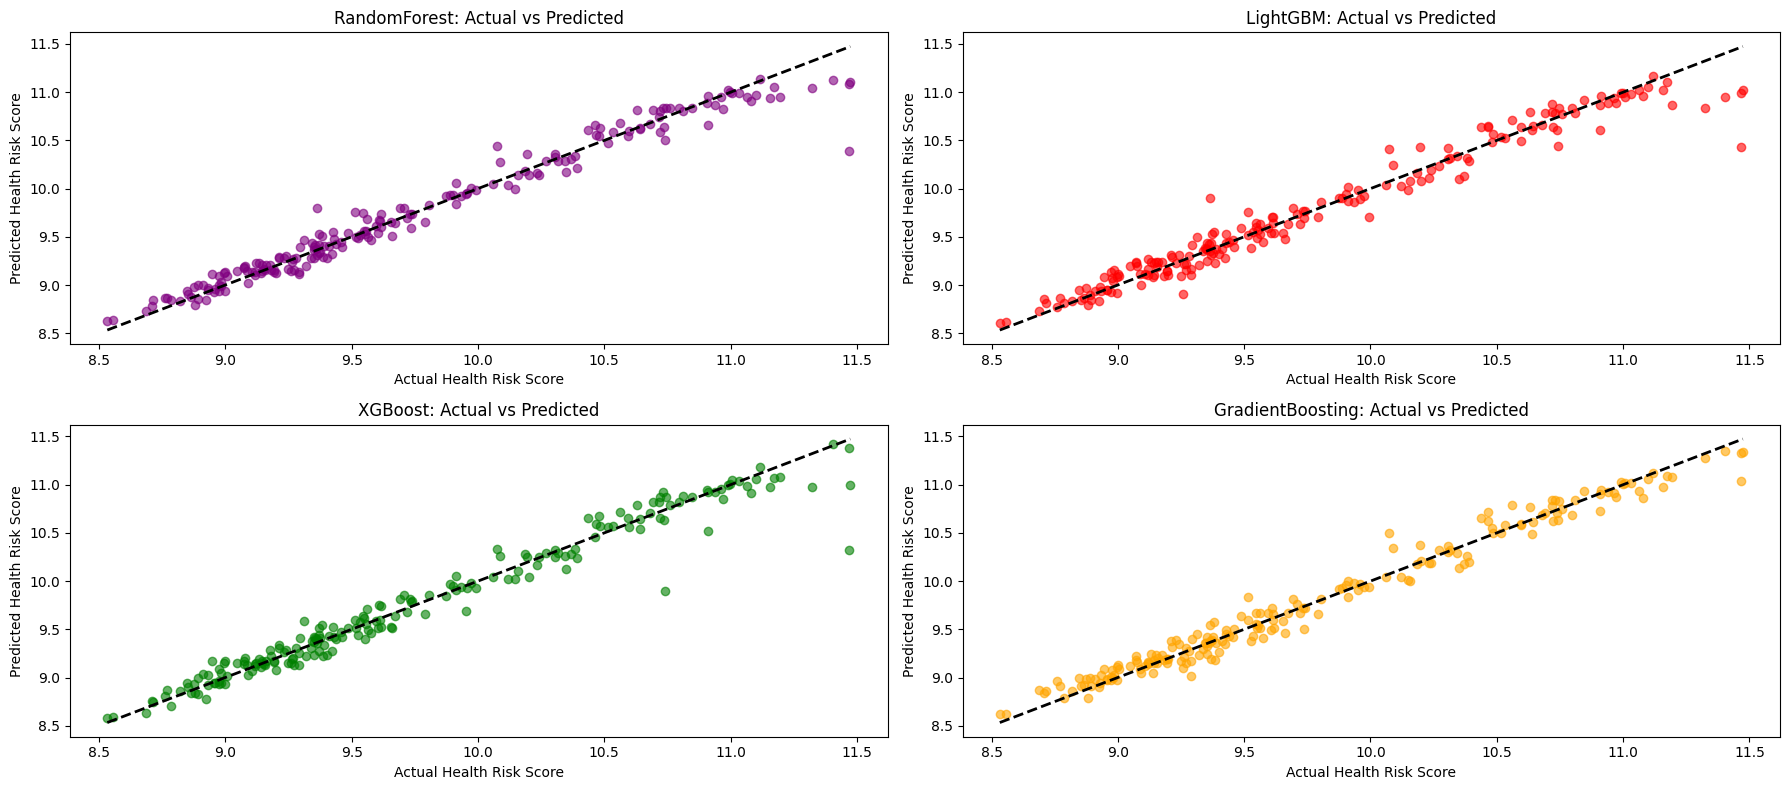

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 선형 그래프: 실제값 vs 예측값 (모든 모델 포함)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual Values', color='blue', linestyle='--', marker='o', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted (RandomForest)', color='purple', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_lgbm, label='Predicted (LightGBM)', color='red', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='-', marker='s', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_gbr, label='Predicted (GradientBoosting)', color='orange', linestyle='-', marker='d', alpha=0.6)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores (All Models)', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Health Risk Score', fontsize=12)
plt.legend()
plt.show()

# 2. 산포도: 실제값 vs 예측값 (모든 모델 포함)
plt.figure(figsize=(18, 8))

# RandomForest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('RandomForest: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# LightGBM
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lgbm, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# XGBoost
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# GradientBoosting
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_gbr, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('GradientBoosting: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# 그래프 레이아웃 설정
plt.tight_layout()
plt.show()

#쓰레기

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting 모델 초기화
gbr = GradientBoostingRegressor(random_state=29)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],          # 학습률
    'n_estimators': [100, 200, 500],             # 트리 개수
    'max_depth': [3, 5, 7],                      # 트리 최대 깊이
    'subsample': [0.8, 1.0],                     # 서브샘플링 비율
    'min_samples_split': [2, 5, 10]              # 노드를 분할하는 데 필요한 최소 샘플 수
}

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# 학습
grid_search.fit(X_train_scaled, y_train)

# 최적 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 최적 모델로 예측 수행
best_gbr_model = grid_search.best_estimator_
y_pred_best_gbr = best_gbr_model.predict(X_test_scaled)

# 성능 평가
mae_best_gbr = mean_absolute_error(y_test, y_pred_best_gbr)
r2_best_gbr = r2_score(y_test, y_pred_best_gbr)

print(f"MAE (Best Model): {mae_best_gbr}")
print(f"R² (Best Model): {r2_best_gbr}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}
Best score: -0.012856410087359969
MAE (Best Model): 0.0832151399181711
R² (Best Model): 0.9735782475673213


In [48]:
# 필요한 라이브러리 불러오기
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import json

# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week','Severity_Score',
'severerisk', 'visibility', 'cloudcover', 'precipcover','Month'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 결과 출력
results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5868
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 24
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b